In [1]:
import logging
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
import pyrepseq as prs
from pyrepseq.metric.tcr_metric import TcrMetric
import pandas as pd
from pandas import DataFrame
import random
from sceptr import variant
from sceptr._lib.sceptr import Sceptr
from sklearn import metrics
from tqdm import tqdm
from typing import Dict

/home/yutanagano/miniconda3/envs/sceptr_publication_analyses/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logging.basicConfig(filename='one_vs_rest.log', encoding='utf-8', level=logging.DEBUG)

## Prep objects

In [7]:
LABELLED_DATA = pd.read_csv("../tcr_data/preprocessed/benchmarking/vdjdb_cleaned.csv")
BACKGROUND_DATA = pd.read_csv("../tcr_data/preprocessed/tanno/test.csv")
BACKGROUND_SAMPLE = BACKGROUND_DATA.sample(n=1000,random_state=420)

EPITOPES = LABELLED_DATA.Epitope.unique()

UPPER_QUANTILE = 0.75
LOWER_QUANTILE = 0.25

models = (
    prs.metric.tcr_metric.Cdr3Levenshtein(),
    prs.metric.tcr_metric.Tcrdist(),
)

In [8]:
def convert_dists_to_scores(dists: ndarray) -> ndarray:
    max_dist = np.max(dists)
    return 1 - dists / max_dist

class FewShotPredictor:
    def __init__(self, metric: TcrMetric, positive_refs: DataFrame, bg_refs: DataFrame) -> None:
        self._metric = metric
        self._positive_refs = positive_refs
        self._bg_refs = bg_refs
    
    def get_nn_inferences(self, queries: DataFrame) -> ndarray:
        cdist_matrix = self._metric.calc_cdist_matrix(queries, self._positive_refs)
        nn_dists = np.min(cdist_matrix, axis=1)
        return convert_dists_to_scores(nn_dists)
    
    def get_avg_dist_inferences(self, queries: DataFrame) -> ndarray:
        cdist_matrix = self._metric.calc_cdist_matrix(queries, self._positive_refs)
        avg_dists = np.mean(cdist_matrix, axis=1)
        return convert_dists_to_scores(avg_dists)

In [9]:
def get_benchmark_results(model: TcrMetric) -> Dict[str, DataFrame]:
    one_shot_results = get_one_shot_benchmark_results(model)
    few_shot_results = get_few_shot_benchmark_results(model)
    collated_results = {**one_shot_results, **few_shot_results}
    return collated_results


def get_one_shot_benchmark_results(model: TcrMetric) -> Dict[str, DataFrame]:
    print(f"Commencing one-shot benchmarking for {model.name}...")

    results = []
    for epitope in tqdm(EPITOPES):
        labelled_data_epitope_mask = LABELLED_DATA.Epitope == epitope
        epitope_references = LABELLED_DATA[labelled_data_epitope_mask]
        cdist_matrix = model.calc_cdist_matrix(LABELLED_DATA, epitope_references)

        aucs = []
        for cdist_idx, tcr_idx in enumerate(epitope_references.index):
            dists = cdist_matrix[:,cdist_idx]
            similarities = convert_dists_to_scores(dists)

            similarities = np.delete(similarities, tcr_idx)
            ground_truth = np.delete(labelled_data_epitope_mask, tcr_idx)

            aucs.append(metrics.roc_auc_score(ground_truth, similarities))

        mean_auc = np.median(aucs)
        upper_bound = np.quantile(aucs, UPPER_QUANTILE)
        lower_bound = np.quantile(aucs, LOWER_QUANTILE)

        results.append({"epitope": epitope, "mean_auc": mean_auc, "error_pos": upper_bound-mean_auc, "error_neg": mean_auc-lower_bound})
    
    return {"one_shot": DataFrame.from_records(results)}


def get_few_shot_benchmark_results(model: TcrMetric) -> Dict[str, DataFrame]:
    print(f"Commencing few-shot benchmarking for {model.name}...")

    summaries = dict()

    for num_shots in (10, 100):
        nn_results = []
        for epitope in tqdm(EPITOPES):
            labelled_data_epitope_mask = LABELLED_DATA.Epitope == epitope
            epitope_references = LABELLED_DATA[labelled_data_epitope_mask]
            ref_index_sets = epitope_references.index.to_list()

            if len(epitope_references) - num_shots < 100:
                logging.info(f"Not enough references for {epitope} for {num_shots} shots, skipping")
                continue

            random.seed("tcrsarecool")
            ref_index_sets = [
                random.sample(ref_index_sets, k=num_shots) for _ in range(100)
            ]
            logging.debug(f"The first five {num_shots}-shot reference sets for {epitope} for {model.name} have indices: {ref_index_sets[:5]}")

            aucs = []
            for ref_index_set in ref_index_sets:
                positive_refs = LABELLED_DATA.loc[ref_index_set]
                queries = LABELLED_DATA.drop(index=ref_index_set)
                ground_truth = queries.Epitope == epitope
                predictor = FewShotPredictor(model, positive_refs=positive_refs, bg_refs=BACKGROUND_SAMPLE)

                nn_scores = predictor.get_nn_inferences(queries)

                aucs.append(metrics.roc_auc_score(ground_truth, nn_scores))
            
            mean_auc = np.median(aucs)
            upper_bound = np.quantile(aucs, UPPER_QUANTILE)
            lower_bound = np.quantile(aucs, LOWER_QUANTILE)

            nn_results.append({"epitope": epitope, "mean_auc": mean_auc, "error_pos": upper_bound-mean_auc, "error_neg": mean_auc-lower_bound})
        
        result = DataFrame.from_records(nn_results)
        summaries[f"{num_shots}_shot_nn"] = result
    
    return summaries

In [10]:
benchmarks_per_metric = {
    model.name: get_benchmark_results(model) for model in models
}

Commencing one-shot benchmarking for CDR3 Levenshtein...


100%|██████████| 12/12 [00:22<00:00,  1.84s/it]


Commencing few-shot benchmarking for CDR3 Levenshtein...


100%|██████████| 12/12 [06:52<00:00, 34.36s/it]


Commencing one-shot benchmarking for tcrdist...


100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


Commencing few-shot benchmarking for tcrdist...


100%|██████████| 12/12 [03:06<00:00, 15.51s/it]


In [17]:
benchmarks_per_metric["CDR3 Levenshtein"]

{'one_shot':            epitope  mean_auc  error_pos  error_neg
 0        GILGFVFTL  0.762057   0.061825   0.029716
 1        NLVPMVATV  0.483284   0.040448   0.039105
 2        GLCTLVAML  0.593765   0.099889   0.090592
 3        YLQPRTFLL  0.592143   0.147398   0.142500
 4        LLWNGPMAV  0.721623   0.070161   0.052631
 5        CINGVCWTV  0.503539   0.080885   0.068259
 6        QYIKWPWYI  0.484291   0.053052   0.046872
 7   TFEYVSQPFLMDLE  0.885879   0.049416  -0.022014
 8        LTDEMIAQY  0.507118   0.027389   0.023953
 9       TTDPSFLGRY  0.545567   0.029873   0.025761
 10       SPRWYFYYL  0.485709   0.036446   0.035086
 11       KTFPPTEPK  0.464629   0.021156   0.020942,
 '10_shot_nn':            epitope  mean_auc  error_pos  error_neg
 0        GILGFVFTL  0.828712   0.013662   0.013831
 1        NLVPMVATV  0.522718   0.033978   0.030143
 2        GLCTLVAML  0.756280   0.037615   0.026295
 3        YLQPRTFLL  0.716944   0.028606   0.010660
 4        LLWNGPMAV  0.800202   0.013

In [11]:
levenshtein_aucs = benchmarks_per_metric["CDR3 Levenshtein"]["one_shot"]
tcrdist_aucs = benchmarks_per_metric["tcrdist"]["one_shot"]

In [13]:
tcrdist_aucs

,epitope,mean_auc,error_pos,error_neg
0,GILGFVFTL,0.810178,0.066042,-0.030161
1,NLVPMVATV,0.485343,0.038862,0.038045
2,GLCTLVAML,0.687993,0.106635,0.108424
3,YLQPRTFLL,0.640209,0.109520,0.103232
4,LLWNGPMAV,0.755651,0.082079,0.061702
5,CINGVCWTV,0.577251,0.114359,0.091751
6,QYIKWPWYI,0.512035,0.063626,0.060750
7,TFEYVSQPFLMDLE,0.913860,0.041217,-0.032109
8,LTDEMIAQY,0.509737,0.028686,0.032082
9,TTDPSFLGRY,0.564165,0.039622,0.036457


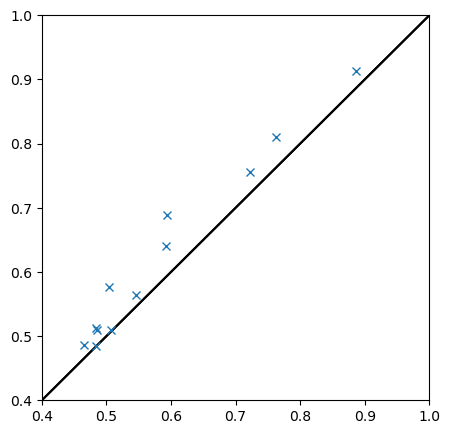

In [15]:

plt.figure(figsize=(5,5))
plt.errorbar(x=levenshtein_aucs["mean_auc"], y=tcrdist_aucs["mean_auc"], fmt="x")
plt.plot(((0,0),(1,1)), c="k")
plt.xlim(0.4,1)
plt.ylim(0.4,1)
plt.show()